In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras 
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from scipy import stats
import tensorflow as tf
import pickle
import warnings
import PrivacyGAN as pg 
from keras.models import load_model
from datetime import datetime


warnings.filterwarnings("ignore")
K.set_image_dim_ordering('th')

### Loading data

In [2]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


### Simple GAN

In [3]:
#generate simple synthetic images of same size as X_train with same balance
X_c = []
y_c = []

for i in range(10):
    print(i)
    In = np.where(y_train==i)
    X = X_train[In]
    K.clear_session()
    optim = Adam(lr=0.0002, beta_1=0.5)
    gen = pg.MNIST_Generator(optim=optim)
    dis = pg.MNIST_Discriminator(optim=optim)
    
    #learn generator per digit 
    (generator, _, _, _) = pg.SimpGAN(X, generator = gen, discriminator = dis, 
                                      optim = optim, 
                                      epochs = 200, batchSize = 256)
    
    noise = np.random.normal(0, 1, size=[len(X), 100])
    X_c += [generator.predict(noise)]
    y_c += [i]*len(X)
    
X_c = np.concatenate(X_c)    
y_c = np.array(y_c)

0
Epochs: 200
Batch size: 256
Batches per epoch: 23.13671875
epoch = 1/200, d_loss=0.550, g_loss=0.747                                                                                                                    
epoch = 2/200, d_loss=0.566, g_loss=0.811                                                                                                                    
epoch = 3/200, d_loss=0.484, g_loss=0.906                                                                                                                    
epoch = 4/200, d_loss=0.544, g_loss=0.902                                                                                                                    
epoch = 5/200, d_loss=0.548, g_loss=1.005                                                                                                                    
epoch = 6/200, d_loss=0.516, g_loss=1.042                                                                                                            

In [12]:
## Shuffle labels around
arr = np.arange(len(X_c))
np.random.shuffle(arr)
X_c = X_c[arr]
y_c = y_c[arr]

In [13]:
#train CNN model
K.clear_session()
y_tr = keras.utils.to_categorical(y_c, 10)
y_t = keras.utils.to_categorical(y_test, 10)

x_train = X_c.reshape(X_c.shape[0], 1, 28, 28)
x_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(1,28, 28)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_tr,
          batch_size=256,
          epochs=25,
          verbose=1,
          validation_data=(x_test, y_t))
score = model.evaluate(x_test, y_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 2s 32us/step - loss: 0.2348 - acc: 0.9253 - val_loss: 0.1439 - val_acc: 0.9625
Epoch 2/25
60000/60000 [==============================] - 2s 25us/step - loss: 0.0209 - acc: 0.9934 - val_loss: 0.1481 - val_acc: 0.9642
Epoch 3/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0099 - acc: 0.9968 - val_loss: 0.1709 - val_acc: 0.9625
Epoch 4/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0052 - acc: 0.9984 - val_loss: 0.1652 - val_acc: 0.9664
Epoch 5/25
60000/60000 [==============================] - 2s 25us/step - loss: 0.0048 - acc: 0.9985 - val_loss: 0.1736 - val_acc: 0.9658
Epoch 6/25
60000/60000 [==============================] - 2s 25us/step - loss: 0.0033 - acc: 0.9989 - val_loss: 0.1767 - val_acc: 0.9678
Epoch 7/25
60000/60000 [==============================] - 2s 25us/step - loss: 0.0031 - acc: 0.9991 - val_loss: 0.1767 - val_acc

In [14]:
#Classification accuracy on test set
score = model.evaluate(x_test, y_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
r_0 = [score[0],score[1]]

Test loss: 0.204078278570221
Test accuracy: 0.9704


### Training on original data

In [7]:
#train CNN model
K.clear_session()
y_tr = keras.utils.to_categorical(y_train, 10)
y_t = keras.utils.to_categorical(y_test, 10)

x_train = X_train.reshape(X_c.shape[0], 1, 28, 28)
x_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(1,28, 28)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_tr,
          batch_size=256,
          epochs=25,
          verbose=1,
          validation_data=(x_test, y_t))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 2s 32us/step - loss: 0.3371 - acc: 0.8950 - val_loss: 0.0610 - val_acc: 0.9802
Epoch 2/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0945 - acc: 0.9721 - val_loss: 0.0419 - val_acc: 0.9861
Epoch 3/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0695 - acc: 0.9798 - val_loss: 0.0354 - val_acc: 0.9879
Epoch 4/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0568 - acc: 0.9835 - val_loss: 0.0323 - val_acc: 0.9887
Epoch 5/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0490 - acc: 0.9851 - val_loss: 0.0295 - val_acc: 0.9910
Epoch 6/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0439 - acc: 0.9867 - val_loss: 0.0283 - val_acc: 0.9900
Epoch 7/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.0384 - acc: 0.9884 - val_loss: 0.0302 - val_acc

In [8]:
#Classification accuracy on test set
score = model.evaluate(x_test, y_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
r_1 = [score[0],score[1]]

Test loss: 0.02728117312252318
Test accuracy: 0.9927


### PrivGAN

In [11]:
#generate simple synthetic images of same size as X_train with same balance
X_c2 = []
y_c2 = []

for i in range(10):
    print(i)
    In = np.where(y_train==i)
    X = X_train[In]
    K.clear_session()
    optim = Adam(lr=0.0002, beta_1=0.5)
    generators = [pg.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
                  pg.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
    discriminators = [pg.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
                      ,pg.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
    pDisc = pg.MNIST_DiscriminatorPrivate(OutSize = 2, 
                                          optim = Adam(lr=0.0002, beta_1=0.5))
    
    (generators, _, _, _, _, _)= pg.privGAN(X, epochs = 200, 
                                                                               disc_epochs=50,
                                                                               batchSize=256,
                                                                               generators = generators, 
                                                                               discriminators = discriminators,
                                                                               pDisc = pDisc,
                                                                               optim = optim,
                                                                               privacy_ratio = 1.0)    
    
    noise1 = np.random.normal(0, 1, size=[len(X)//2, 100])
    noise2 = np.random.normal(0, 1, size=[len(X)//2, 100])
    X_c2 += [generators[0].predict(noise1)]
    X_c2 += [generators[1].predict(noise2)]
    y_c2 += [i]*(len(noise1) + len(noise2))
    
X_c2 = np.concatenate(X_c2)    
y_c2 = np.array(y_c2)

0
Train on 5923 samples, validate on 5923 samples
Epoch 1/50
5923/5923 [==============================] - 1s 109us/step - loss: 0.8014 - val_loss: 0.6865
Epoch 2/50
5923/5923 [==============================] - 0s 17us/step - loss: 0.6912 - val_loss: 0.7059
Epoch 3/50
5923/5923 [==============================] - 0s 17us/step - loss: 0.6888 - val_loss: 0.6957
Epoch 4/50
5923/5923 [==============================] - 0s 16us/step - loss: 0.6871 - val_loss: 0.8951
Epoch 5/50
5923/5923 [==============================] - 0s 17us/step - loss: 0.6896 - val_loss: 0.7027
Epoch 6/50
5923/5923 [==============================] - 0s 18us/step - loss: 0.6765 - val_loss: 0.6892
Epoch 7/50
5923/5923 [==============================] - 0s 18us/step - loss: 0.6708 - val_loss: 0.6612
Epoch 8/50
5923/5923 [==============================] - 0s 18us/step - loss: 0.6722 - val_loss: 0.6504
Epoch 9/50
5923/5923 [==============================] - 0s 18us/step - loss: 0.6624 - val_loss: 0.6859
Epoch 10/50
5923/5923 

In [35]:
## Shuffle labels around
arr = np.arange(len(X_c2))
np.random.shuffle(arr)
X_c2 = X_c2[arr]
y_c2 = y_c2[arr]

In [16]:
#train CNN model
K.clear_session()
y_tr = keras.utils.to_categorical(y_c2, 10)
y_t = keras.utils.to_categorical(y_test, 10)

x_train = X_c2.reshape(X_c2.shape[0], 1, 28, 28)
x_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(1,28, 28)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_tr,
          batch_size=256,
          epochs=25,
          verbose=1,
          validation_data=(x_test, y_t))

Train on 59994 samples, validate on 10000 samples
Epoch 1/25
59994/59994 [==============================] - 2s 32us/step - loss: 0.1637 - acc: 0.9486 - val_loss: 0.2957 - val_acc: 0.9323
Epoch 2/25
59994/59994 [==============================] - 2s 26us/step - loss: 0.0084 - acc: 0.9976 - val_loss: 0.3910 - val_acc: 0.9269
Epoch 3/25
59994/59994 [==============================] - 2s 26us/step - loss: 0.0040 - acc: 0.9989 - val_loss: 0.3855 - val_acc: 0.9345
Epoch 4/25
59994/59994 [==============================] - 2s 26us/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.3741 - val_acc: 0.9357
Epoch 5/25
59994/59994 [==============================] - 2s 26us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.3738 - val_acc: 0.9377
Epoch 6/25
59994/59994 [==============================] - 2s 26us/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.3833 - val_acc: 0.9386
Epoch 7/25
59994/59994 [==============================] - 2s 26us/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.4369 - val_acc

In [17]:
score = model.evaluate(x_test, y_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
r_2 = [score[0],score[1]]

Test loss: 0.49291563795822196
Test accuracy: 0.9377


### Compare performance of different CNN models

Text(0, 0.5, 'Accuracy')

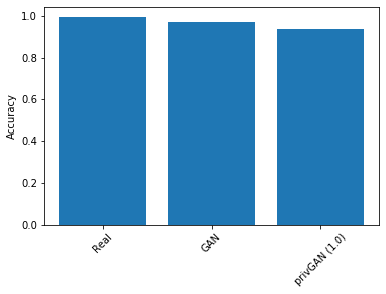

In [26]:
plt.bar([0,1,2],[r_1[1],r_0[1],r_2[1]])
plt.xticks([0,1,2],['Real','GAN','privGAN (1.0)'], rotation=45)
plt.ylabel('Accuracy')